In [1]:
import numpy as np
from util.plot import plot_cdf,color_list,plot_cdf_sub
from util.consts import MTU,UNIT_G,LINK_TO_DELAY_DICT,SIZE_BUCKET_LIST_OUTPUT,get_base_delay_transmission,get_base_delay,get_size_bucket_list_output,SIZE_BUCKET_LIST_LABEL_OUTPUT,balance_bins,balance_bins_label
import matplotlib.pyplot as plt
import json
import glob
import os
from collections import defaultdict

topo_type_ori="_topo-pl-x_"
lr=10
rotation_angle=30
np.random.seed(0)

In [2]:
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8
def get_base_delay_pmn(sizes, n_links_passed, lr_bottleneck):
    pkt_head = np.clip(sizes, a_min=0, a_max=MTU)
    delay_propagation = DELAY_PROPAGATION_BASE * n_links_passed
    pkt_size=(pkt_head + HEADER_SIZE) * BYTE_TO_BIT
    delay_transmission = pkt_size / lr_bottleneck

    return delay_propagation + delay_transmission

dir_train: /data2/lichenni/output_perflow/fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 4000 tracks
dir_train: /data2/lichenni/output_perflow/fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 4000 tracks
(2, 4000, 5, 2)
dir_train: /data2/lichenni/output_perflow/fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 19973 tracks
dir_train: /data2/lichenni/output_perflow/fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 19973 tracks
(2, 19973, 5, 2)
dir_train: /data2/lichenni/output_perflow/fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 19074 tracks
dir_train

/tmp/ipykernel_3741890/1746857788.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(fig_index,figsize=(12, 6))


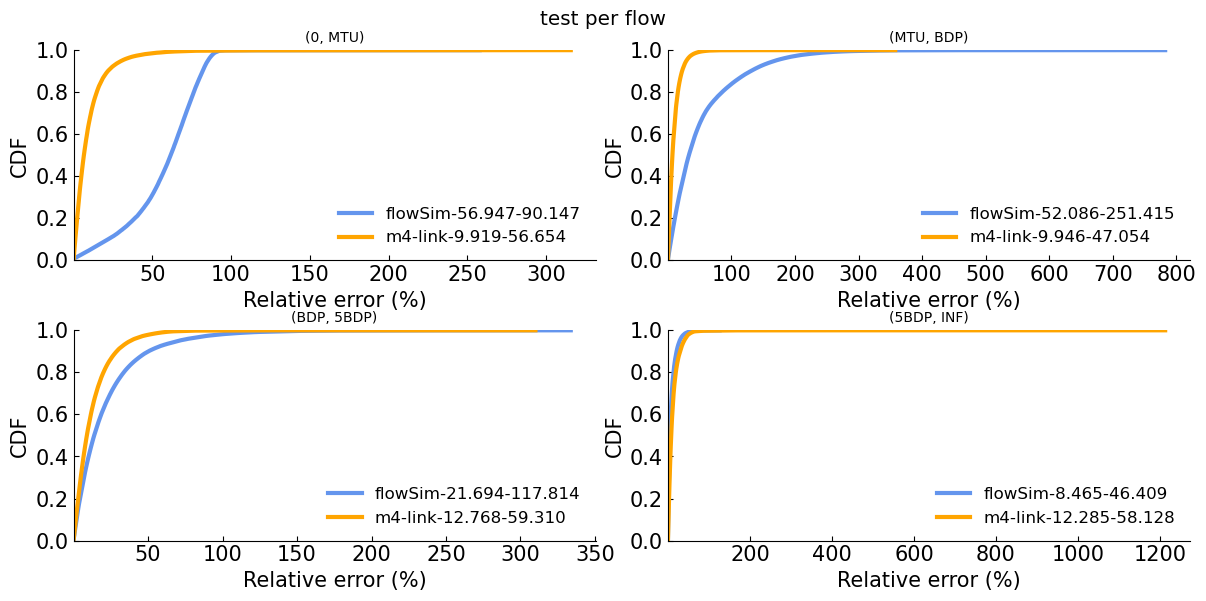

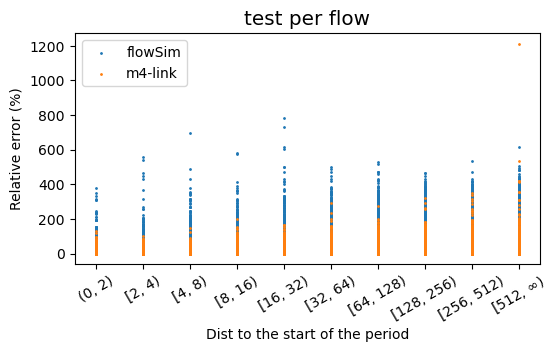

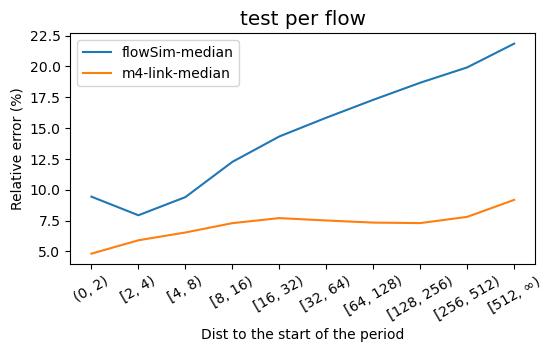

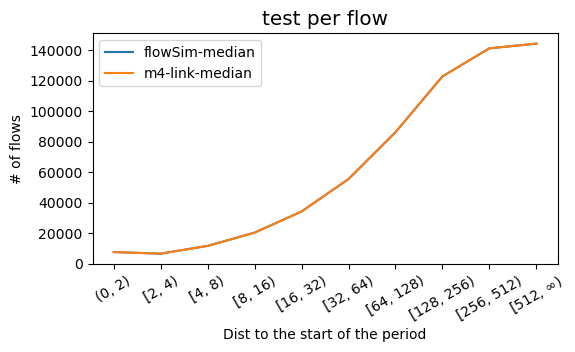

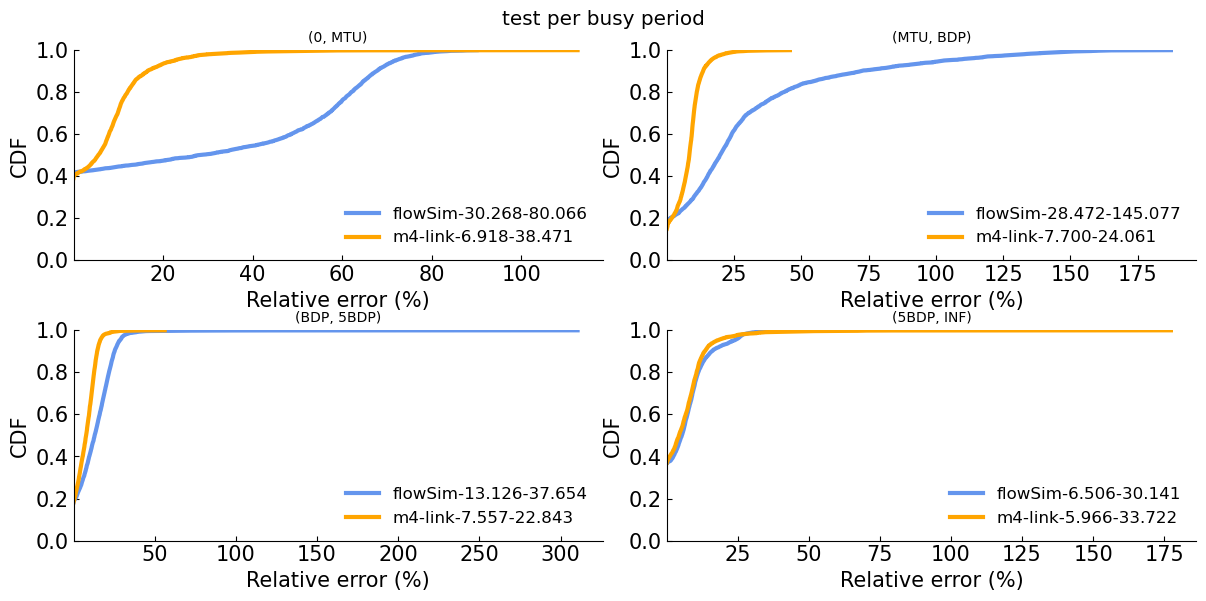

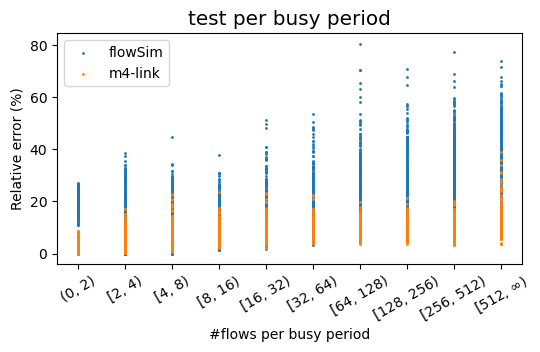

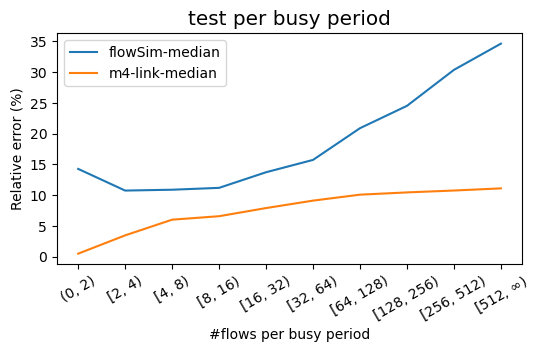

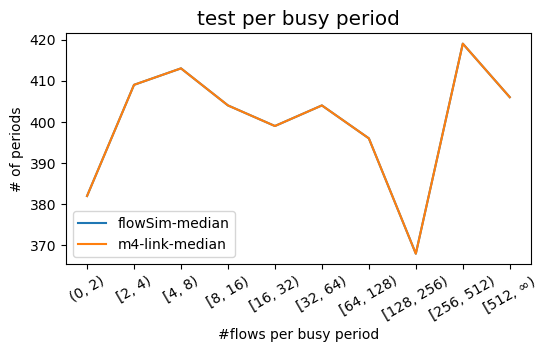

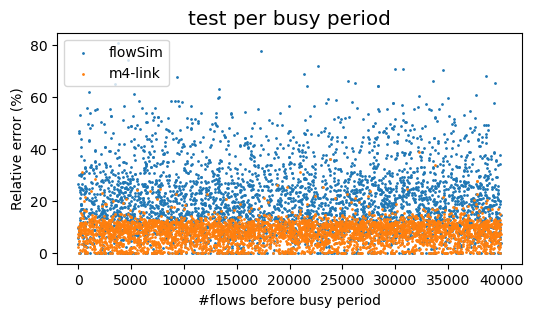

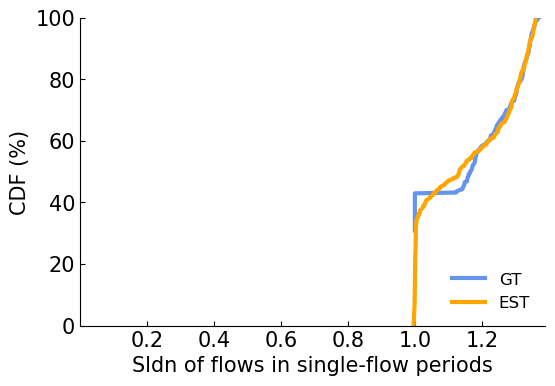

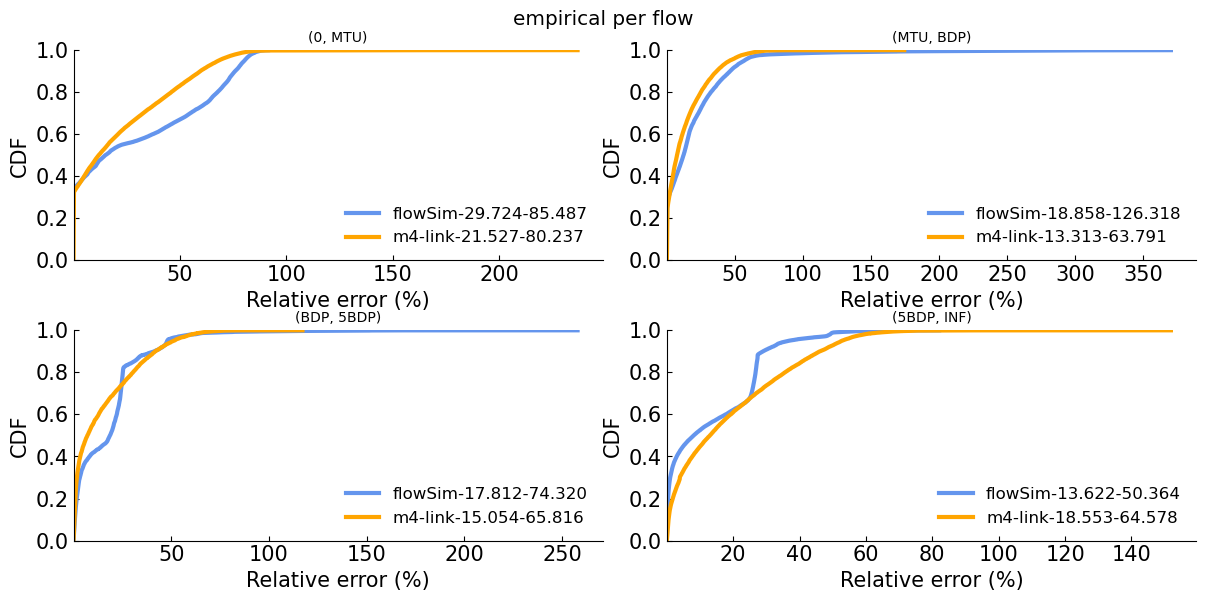

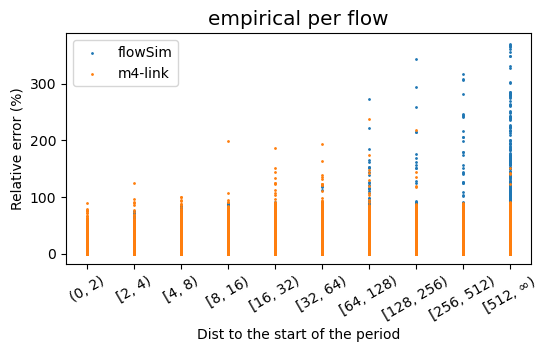

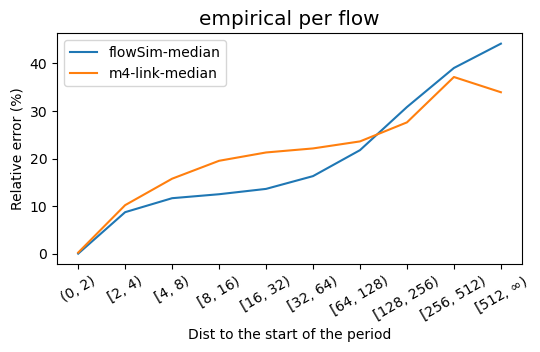

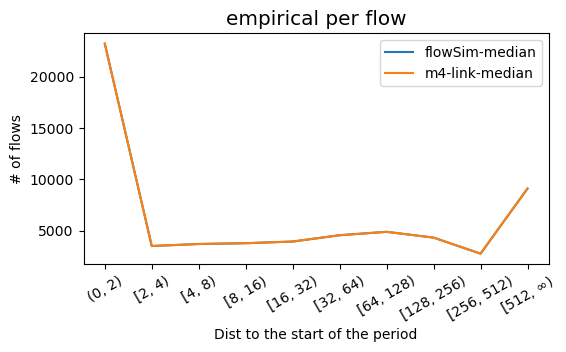

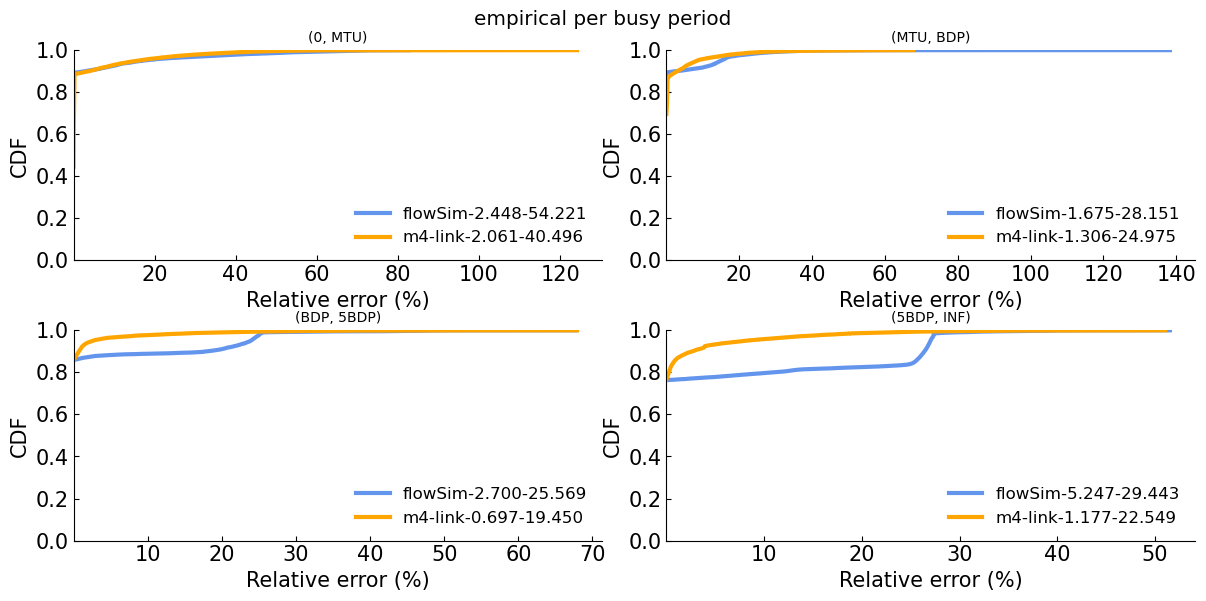

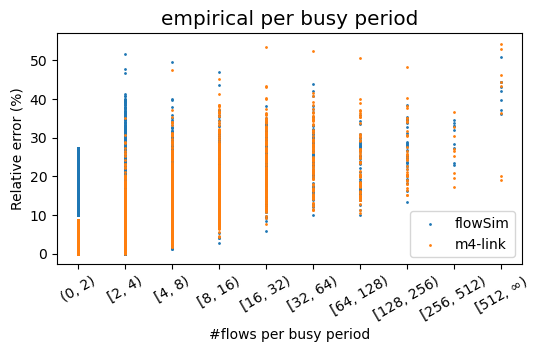

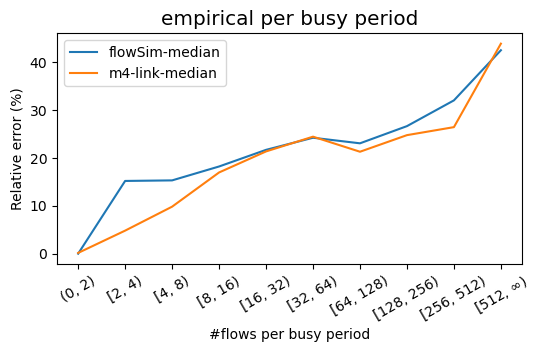

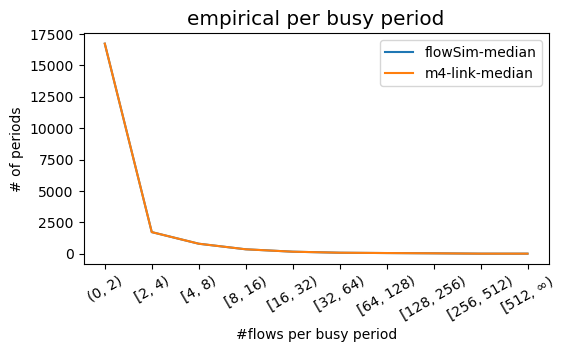

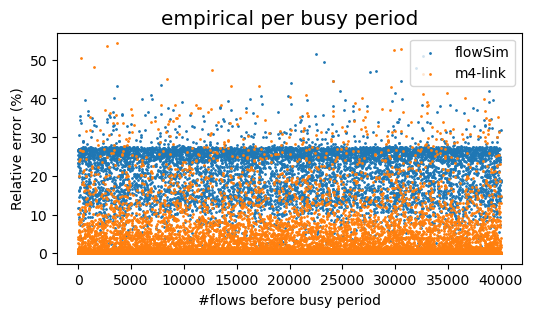

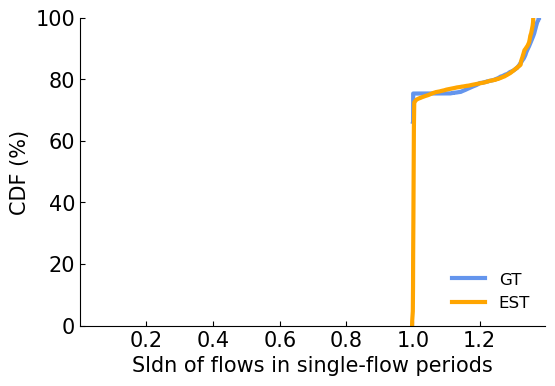

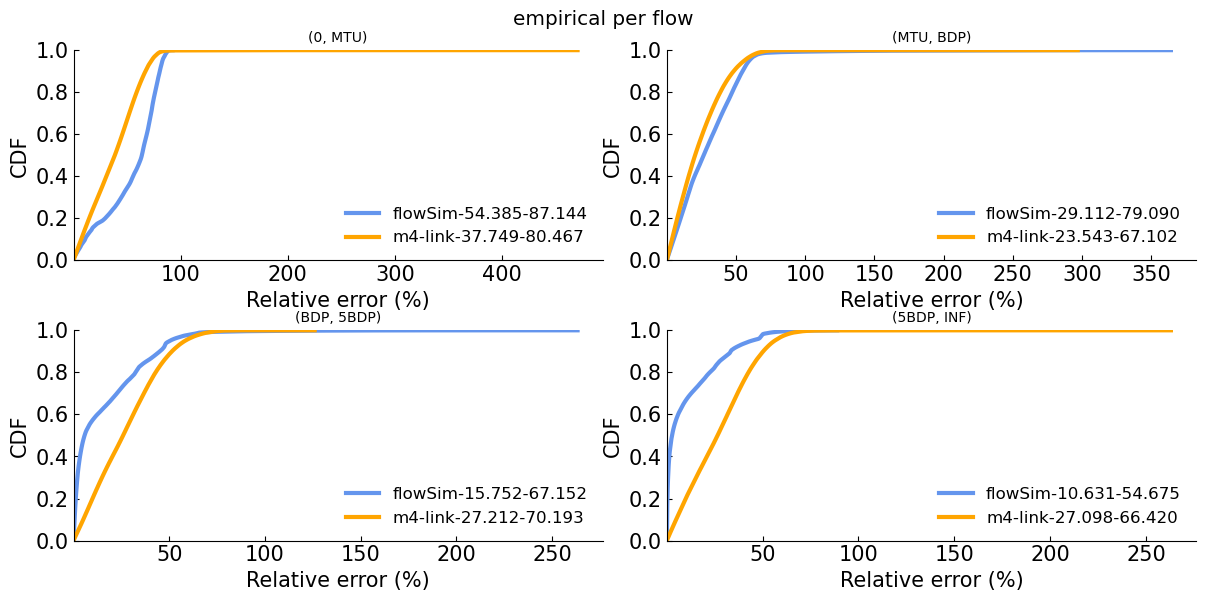

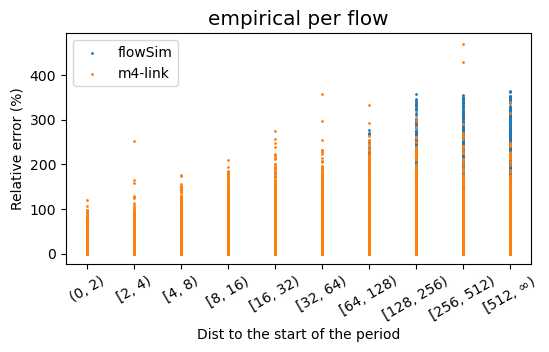

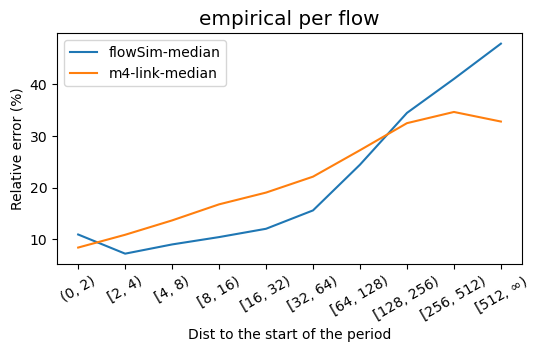

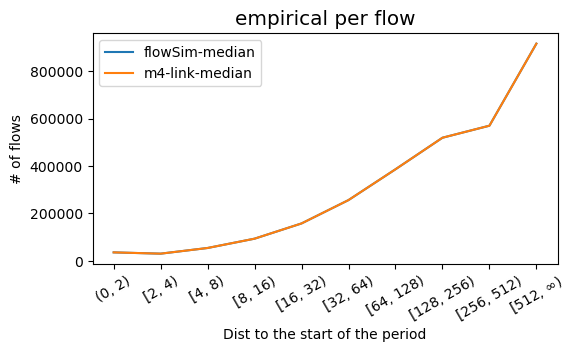

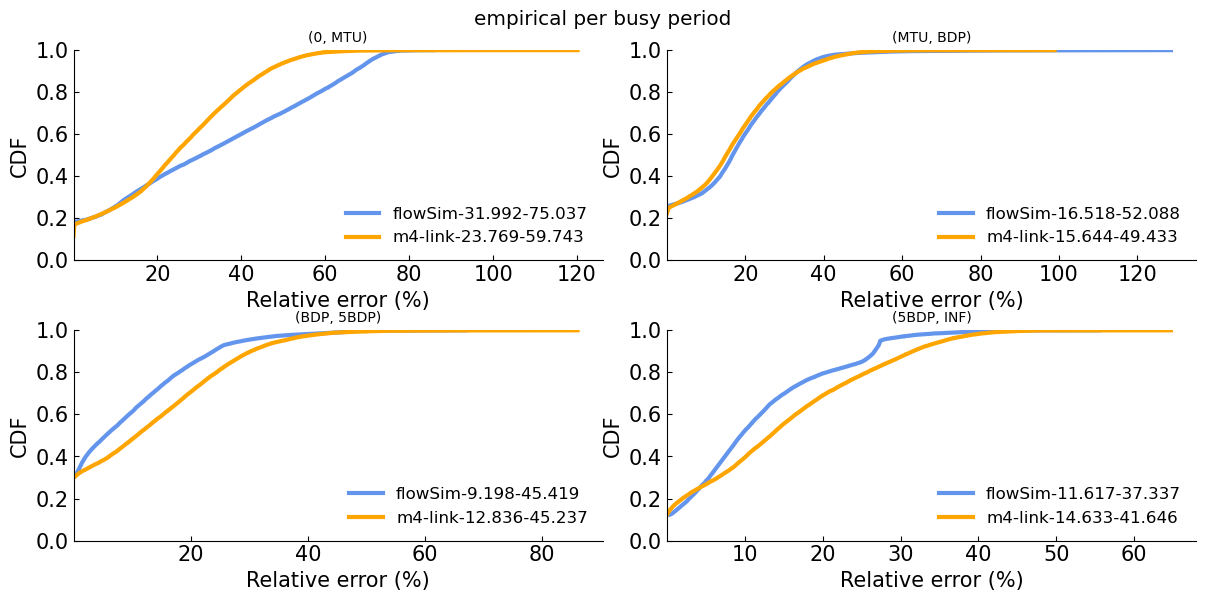

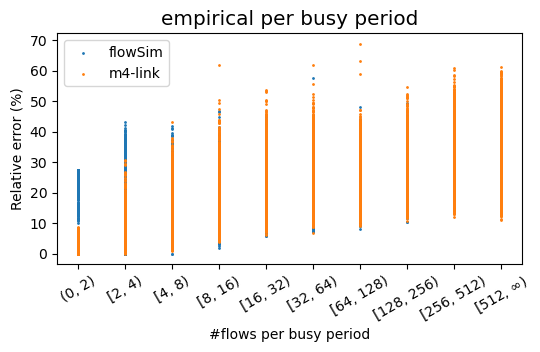

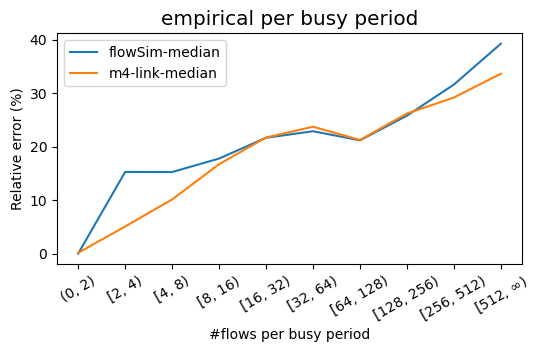

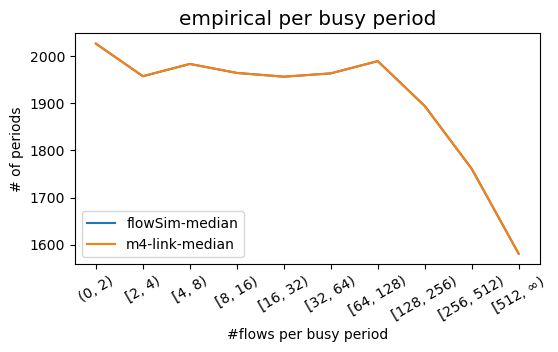

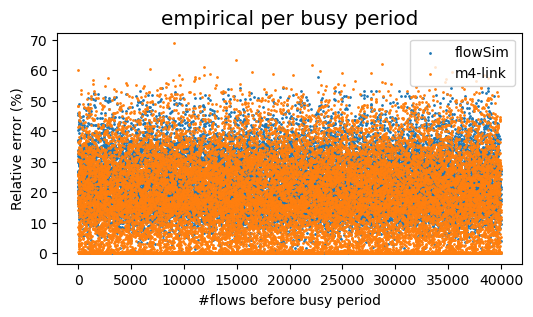

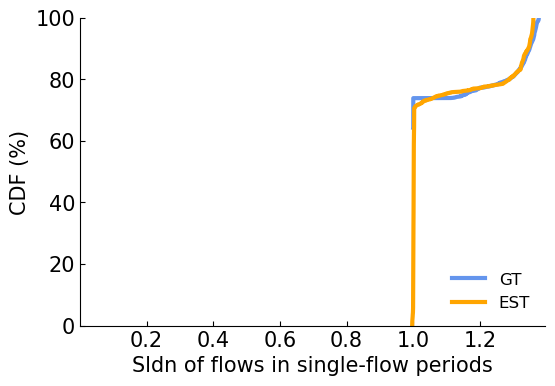

In [5]:
dir_input_synthetic="/data2/lichenni/path_perflow_link"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                # 'fct_lstm_uniform_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                # 'fct_lstm_uniform_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                # 'fct_lstm_balanced_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                # 'fct_lstm_balanced_flowsim_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_final_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps'
                ]
version_id_list=[
    [0],[0],[0],[0]
]

# title_str_list = ["flowSim","uniform","balanced","balanced+flowsim"]
title_str_list = ["flowSim","m4-link"]
main_title_list=['test','empirical','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0, 1,2]:
    res_total_per_flow=[]
    num_total_per_flow=[]
    res_total_per_seg=[]
    num_total_per_seg=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(1000):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                            # print(statss.item())
                            # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                            # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                            if float(statss.item().get("load_bottleneck_target")) > 0.8: continue
                            # if float(statss.item().get("ias_sigma_candidate")) > 1.5: continue
                            
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_i0_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}_i0", int(segment_id), None)
                                    )
            
            len_tracks=len(data_list_test)
            
            # if len(data_list_test)>20000:
            #     data_list_test_idx=np.random.choice(len(data_list_test),20000, replace=False)
            #     data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[[[],[]] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            num_per_flow=[[] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            res_per_seg=[]
            num_per_seg=[]
            
            num_flows_to_gt=[]
            for spec, src_dst_pair_target, topo_type, segment_id, _ in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                # output = data['output'].flatten()
                
                dir_input_tmp=f"{dir_input}/{spec}"
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                
                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                busy_period=busy_periods[segment_id]
                fid=np.arange(int(busy_period[0]),int(busy_period[1])+1)
                fid_rank=fid-np.min(fid)
                
                if program_name_idx==0:
                    fcts_flowsim = np.load(f"{dir_input_tmp}/fct_flowsim.npy")
                    n_links_passed=np.ones_like(fcts_flowsim)*2
                    base_delay=get_base_delay_pmn(sizes_flowsim,n_links_passed,lr)
                    i_fcts_flowsim = (sizes_flowsim + np.ceil(sizes_flowsim / MTU) * HEADER_SIZE) * BYTE_TO_BIT / lr + base_delay
                    fcts_flowsim += base_delay
                    queue_len_est = np.divide(fcts_flowsim, i_fcts_flowsim)[fid]
                else:
                    queue_len_est = data['est'].flatten()
                fcts=np.load(f"{dir_input_tmp}/fct{topo_type}.npy")
                fcts_i=np.load(f"{dir_input_tmp}/fct_i{topo_type}.npy")
                output=np.divide(fcts, fcts_i)[fid]
                
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)
                
                if len(output)==1:
                    num_flows_to_gt.append([output[0],queue_len_est[0]])
                    # print(f"len(output): {len(output)}, {len(fid)}")  
                
                sizes=sizes_flowsim[fid]

                bins=np.digitize(sizes,size_bucket_list)
                res_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,len(metric_label_list)))  
                num_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,2))
                
                for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
                    gt = np.extract(bins==i, output)
                    estimated = np.extract(bins==i, queue_len_est)
                    fid_rank_tmp=np.extract(bins==i, fid_rank)
                    fid_tmp=np.extract(bins==i, fid)
                    if len(gt)==0:
                        continue
                    res_per_flow[i][0].extend(np.abs(gt - estimated))
                    res_per_flow[i][1].extend(np.abs(gt - estimated)/gt*100)
                    num_per_flow[i].extend(fid_rank_tmp)
                    
                    res_per_bucket[i,0]=np.mean(np.abs(gt - estimated))
                    res_per_bucket[i,1]=np.mean(np.abs(gt - estimated)/gt)*100
                    num_per_bucket[i,0]=len(gt)
                    num_per_bucket[i,1]=np.min(fid_tmp)
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][0].extend(np.abs(output - queue_len_est))
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][1].extend((np.abs(output - queue_len_est)/output*100))
                num_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)].extend(fid_rank)
                res_per_bucket[-1,0]=np.mean(np.abs(output - queue_len_est))
                res_per_bucket[-1,1]=np.mean(np.abs(output - queue_len_est)/output)*100
                num_per_bucket[-1,0]=len(output)
                num_per_bucket[-1,1]=np.min(fid)
                
                res_per_seg.append(res_per_bucket) 
                num_per_seg.append(num_per_bucket)
            res_total_per_flow.append(res_per_flow)
            num_total_per_flow.append(num_per_flow)
            res_total_per_seg.append(res_per_seg)
            num_total_per_seg.append(num_per_seg)
    res_total_per_seg=np.array(res_total_per_seg)
    print(res_total_per_seg.shape) 
    num_total_per_seg=np.array(num_total_per_seg)
    
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmean(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        plt.legend()
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[np.median(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"# of flows")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmean(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[np.median(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"# of periods")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        # plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        # for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
        #     res=[x[:,i,metric_idx] for x in res_total_per_seg]
        #     res_num=[x[:,i,1] for x in num_total_per_seg]
        #     plt.subplot(2, 2, i + 1)
        #     for j in range(len(program_name_list)):
        #         plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        #     plt.legend()
        #     plt.xlabel("#flows before busy period")
        #     plt.ylabel(f"{metric_label_list[metric_idx]}")
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[x[:,-1,1] for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.legend()
        plt.xlabel("#flows before busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        
        plot_cdf(
            np.array(num_flows_to_gt).transpose(),
            None,
            ['GT', 'EST'],
            x_label="Sldn of flows in single-flow periods",
            log_switch=False,
            rotate_xaxis=False,
            ylim_low=0,
            # xlim=1,
            xlim_bottom=0.001,
            fontsize=15,
            legend_font=12,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_index
        )
        fig_index+=1

In [ ]:
dir_input_synthetic="/data2/lichenni/path_perflow_busy"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_bi_balanced_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_uniform_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_weighted_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0],[0]
]

segments_per_seq=200
title_str_list = ["balanced","uniform","weighted"]
main_title_list=['test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0,1]:
    res_total_per_flow=[]
    num_total_per_flow=[]
    res_total_per_seg=[]
    num_total_per_seg=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            elif version_id_test==1:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(0, 500):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}", int(segment_id))
                                    )
            
            len_tracks=len(data_list_test)
            
            data_list_test_idx=np.random.choice(len(data_list_test),10000, replace=False)
            data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[[[],[]] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT))]
            num_per_flow=[[] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT))]
            res_per_seg=[]
            num_per_seg=[]
            
            for spec, src_dst_pair_target, topo_type, segment_id in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                # data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
                est = data['est']
                output = data['output']
                
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                fid=[int(flow_id) for flow_id in busy_periods[segment_id]]
                fid_rank=fid-np.min(fid)
                
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins=np.digitize(sizes,size_bucket_list)
                res_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,len(metric_label_list)))  
                num_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,2))
                
                for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
                    gt = np.extract(bins==i, output)
                    estimated = np.extract(bins==i, est)
                    fid_rank_tmp=np.extract(bins==i, fid_rank)
                    fid_tmp=np.extract(bins==i, fid)
                    if len(gt)==0:
                        continue
                    res_per_flow[i][0].extend(np.abs(gt - estimated))
                    res_per_flow[i][1].extend(np.abs(gt - estimated)/gt*100)
                    num_per_flow[i].extend(fid_rank_tmp)
                    
                    res_per_bucket[i,0]=np.mean(np.abs(gt - estimated))
                    res_per_bucket[i,1]=np.mean(np.abs(gt - estimated)/gt)*100
                    num_per_bucket[i,0]=len(gt)
                    num_per_bucket[i,1]=np.min(fid_tmp)
                res_per_bucket[-1,0]=np.mean(np.abs(output - est))
                res_per_bucket[-1,1]=np.mean(np.abs(output - est)/output)*100
                num_per_bucket[-1,0]=len(output)
                num_per_bucket[-1,1]=np.min(fid)
                
                res_per_seg.append(res_per_bucket) 
                num_per_seg.append(num_per_bucket)
            res_total_per_flow.append(res_per_flow)
            num_total_per_flow.append(num_per_flow)
            res_total_per_seg.append(res_per_seg)
            num_total_per_seg.append(num_per_seg)
    res_total_per_seg=np.array(res_total_per_seg)
    print(res_total_per_seg.shape) 
    num_total_per_seg=np.array(num_total_per_seg)
    
    for metric_idx in range(len(metric_label_list)):
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
            res_num=[np.array(x[i]) for x in num_total_per_flow]
            plt.subplot(2, 2, i + 1)
            for j in range(len(program_name_list)):
                plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
            plt.legend()
            plt.xlabel("Dist to the start of the period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            res_num=[x[:,i,0] for x in num_total_per_seg]
            plt.subplot(2, 2, i + 1)
            for j in range(len(program_name_list)):
                plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
            plt.legend()
            plt.xscale('log')
            plt.xlabel("#flows per busy period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            res_num=[x[:,i,1] for x in num_total_per_seg]
            plt.subplot(2, 2, i + 1)
            for j in range(len(program_name_list)):
                plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
            plt.legend()
            plt.xlabel("#flows before busy period")
            plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1

In [ ]:
dir_input_synthetic="/data2/lichenni/path_perflow_busy"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_bi_balanced_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0]
]

file_tag = "-abs"
enable_abs = True
title_str_list = ["lstm-bi"]
main_title_list=['test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0]:
    res_total_per_flow=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            elif version_id_test==1:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(0, 500):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}", int(segment_id))
                                    )
            
            len_tracks=len(data_list_test)
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[]
            
            for spec, src_dst_pair_target, topo_type, segment_id in [data_list_test[i] for i in range(100)]:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                est = data['est']
                output = data['output']
                
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                fid=[int(flow_id) for flow_id in busy_periods[segment_id]]
                if len(fid)<10: continue
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins_target=np.digitize(sizes,size_bucket_list)

                plt.figure(fig_index,figsize=(12, 6))
                plt.suptitle(f"{title_str_list[program_name_idx]}")
                for i in range(len(SIZE_BUCKET_LIST_OUTPUT)):
                    gt = np.extract(bins_target==i, output)
                    estimated = np.extract(bins_target==i, est)
                    
                    plt.subplot(2, 2, i + 1)
                    plt.title(f"{SIZE_BUCKET_LIST_OUTPUT[i]}-#{len(gt)}, gt-mean:{np.mean(gt):.2f}KB, est-mean:{np.mean(estimated):.2f}KB")
                    if(len(gt)==0): continue
                    
                    
                    plt.plot(estimated, label="Estimated", linewidth=1,color=color_list[1])
                    
                    plt.plot(gt, label="Ground truth", linewidth=1,color=color_list[3],linestyle='dashed')

                    # plt.axhline(99, color='green', linewidth=0.5)
                    # plt.xscale('log')
                    plt.xlabel('Flow ID')
                    plt.legend()
                    
                    # plt.xlim([0, 16])
                    # plt.ylim([80, 100])
                plt.tight_layout()
                fig_index+=1

In [ ]:
dir_input_synthetic="/data2/lichenni/path_perflow_busy"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_bi_balanced_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_uniform_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_bi_weighted_shard5000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0],[0]
]

segments_per_seq=200
title_str_list = ["balanced","uniform","weighted"]
main_title_list=['test','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [0,1]:
    res_total_per_flow=[]
    num_total_per_flow=[]
    res_total_per_seg=[]
    num_total_per_seg=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            elif version_id_test==1:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(500):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                            # print(statss.item())
                            # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                            # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                            # if float(statss.item().get("load_bottleneck_target")) <= 0.3: continue
                            # if float(statss.item().get("ias_sigma_candidate")) < 1.5: continue
                            
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}", int(segment_id))
                                    )
            
            len_tracks=len(data_list_test)
            
            data_list_test_idx=np.random.choice(len(data_list_test),10000, replace=False)
            data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[[[],[]] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            num_per_flow=[[] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            res_per_seg=[]
            num_per_seg=[]
            
            num_flows_to_gt=[]
            for spec, src_dst_pair_target, topo_type, segment_id in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                queue_len_est = data['est'].flatten()
                output = data['output'].flatten()
                
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                fid=[int(flow_id) for flow_id in busy_periods[segment_id]]
                fid_rank=fid-np.min(fid)
                if len(output)==1:
                    num_flows_to_gt.append([output[0],queue_len_est[0]])
                    # print(f"len(output): {len(output)}, {len(fid)}")  
                
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins=np.digitize(sizes,size_bucket_list)
                res_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,len(metric_label_list)))  
                num_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,2))
                
                for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
                    gt = np.extract(bins==i, output)
                    estimated = np.extract(bins==i, queue_len_est)
                    fid_rank_tmp=np.extract(bins==i, fid_rank)
                    fid_tmp=np.extract(bins==i, fid)
                    if len(gt)==0:
                        continue
                    res_per_flow[i][0].extend(np.abs(gt - estimated))
                    res_per_flow[i][1].extend(np.abs(gt - estimated)/gt*100)
                    num_per_flow[i].extend(fid_rank_tmp)
                    
                    res_per_bucket[i,0]=np.mean(np.abs(gt - estimated))
                    res_per_bucket[i,1]=np.mean(np.abs(gt - estimated)/gt)*100
                    num_per_bucket[i,0]=len(gt)
                    num_per_bucket[i,1]=np.min(fid_tmp)
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][0].extend(np.abs(output - queue_len_est))
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][1].extend((np.abs(output - queue_len_est)/output*100))
                num_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)].extend(fid_rank)
                res_per_bucket[-1,0]=np.mean(np.abs(output - queue_len_est))
                res_per_bucket[-1,1]=np.mean(np.abs(output - queue_len_est)/output)*100
                num_per_bucket[-1,0]=len(output)
                num_per_bucket[-1,1]=np.min(fid)
                
                res_per_seg.append(res_per_bucket) 
                num_per_seg.append(num_per_bucket)
            res_total_per_flow.append(res_per_flow)
            num_total_per_flow.append(num_per_flow)
            res_total_per_seg.append(res_per_seg)
            num_total_per_seg.append(num_per_seg)
    res_total_per_seg=np.array(res_total_per_seg)
    print(res_total_per_seg.shape) 
    num_total_per_seg=np.array(num_total_per_seg)
    
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        # plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        # for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
        #     res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
        #     res_num=[np.array(x[i]) for x in num_total_per_flow]
        #     plt.subplot(2, 2, i + 1)
        #     for j in range(len(program_name_list)):
        #         plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        #     plt.legend()
        #     plt.xlabel("Dist to the start of the period")
        #     plt.ylabel(f"{metric_label_list[metric_idx]}")
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        print(res)
        res_num=[np.array(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)]) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            plt.plot([np.median(stats_per_period[key]) for key in stats_per_period.keys()],label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmedian(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        # plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        # for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
        #     res=[x[:,i,metric_idx] for x in res_total_per_seg]
        #     res_num=[x[:,i,0] for x in num_total_per_seg]
        #     plt.subplot(2, 2, i + 1)
        #     for j in range(len(program_name_list)):
        #         plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        #     plt.legend()
        #     plt.xlabel("#flows per busy period")
        #     plt.ylabel(f"{metric_label_list[metric_idx]}")
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[x[:,-1,0] for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
            print(f"program_name: {program_name_list[j]}")
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            plt.plot([np.median(stats_per_period[key]) for key in stats_per_period.keys()],label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        # plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        # for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
        #     res=[x[:,i,metric_idx] for x in res_total_per_seg]
        #     res_num=[x[:,i,1] for x in num_total_per_seg]
        #     plt.subplot(2, 2, i + 1)
        #     for j in range(len(program_name_list)):
        #         plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        #     plt.legend()
        #     plt.xlabel("#flows before busy period")
        #     plt.ylabel(f"{metric_label_list[metric_idx]}")
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[x[:,-1,1] for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.legend()
        plt.xlabel("#flows before busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        
        plot_cdf(
            np.array(num_flows_to_gt).transpose(),
            None,
            ['GT', 'EST'],
            x_label="Sldn of flows in single-flow periods",
            log_switch=False,
            rotate_xaxis=False,
            ylim_low=0,
            # xlim=1,
            xlim_bottom=0.001,
            fontsize=15,
            legend_font=12,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_index
        )
        fig_index+=1

dir_train: /data2/lichenni/output_perflow/fct_lstm_uniform_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_uniform_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 19982 tracks
dir_train: /data2/lichenni/output_perflow/fct_lstm_balanced_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps/version_0/
fct_lstm_balanced_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps loads 19982 tracks
(2, 19982, 5, 2)


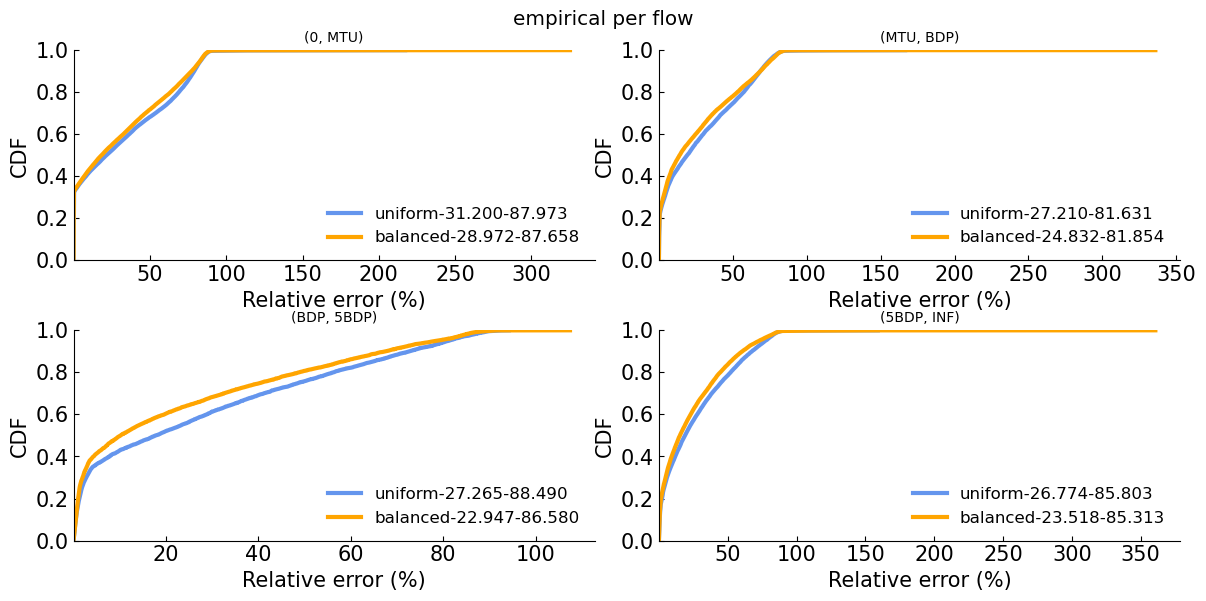

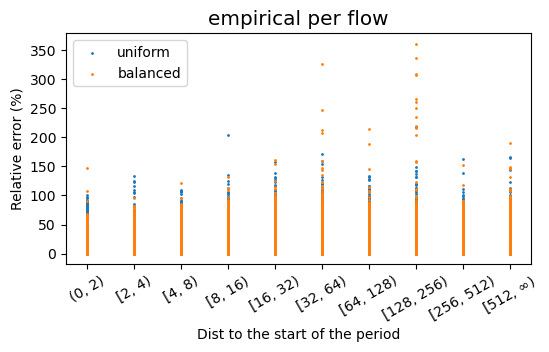

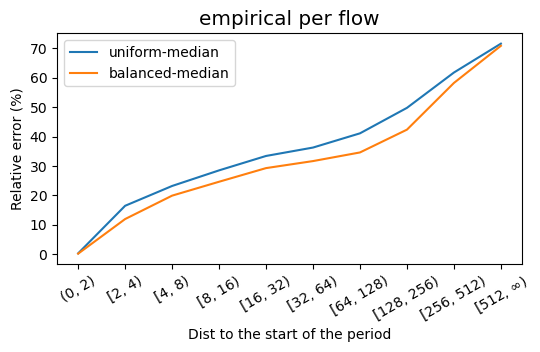

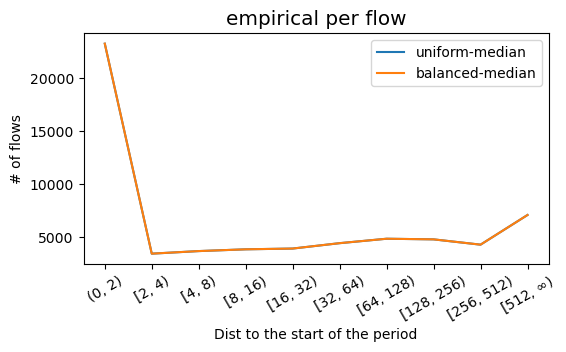

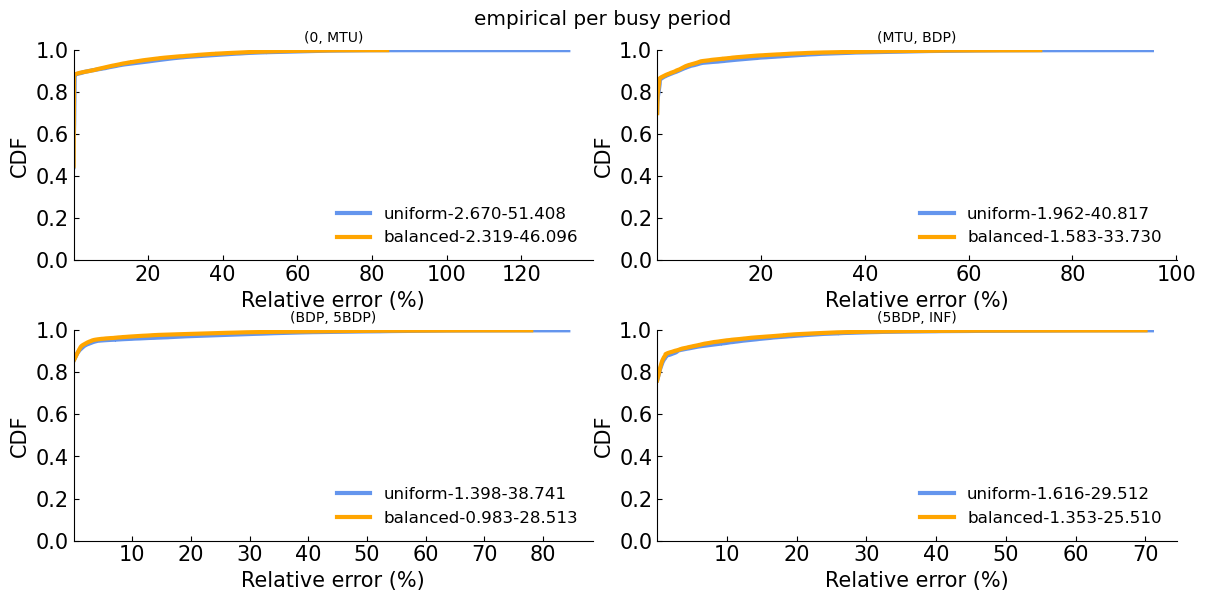

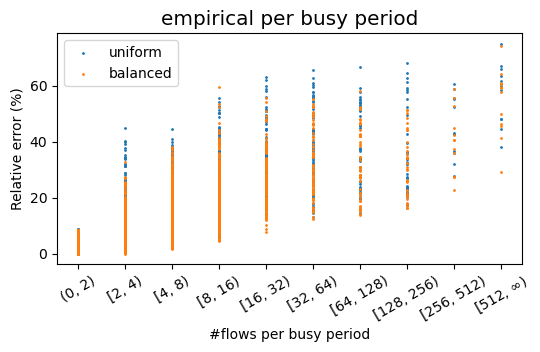

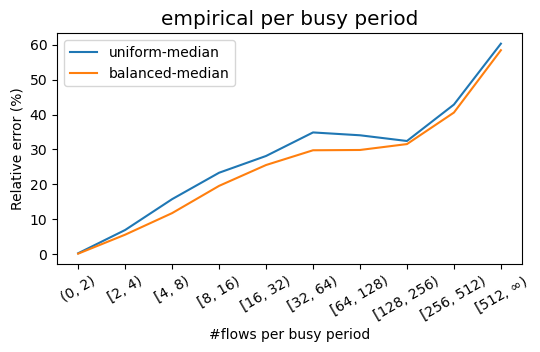

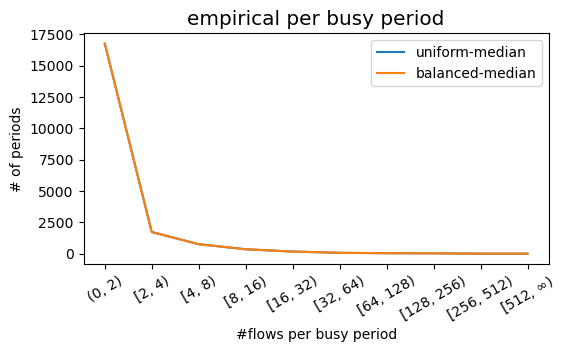

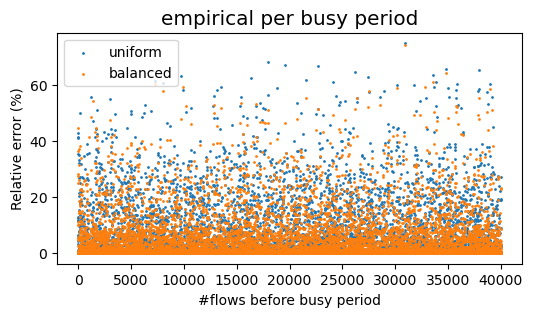

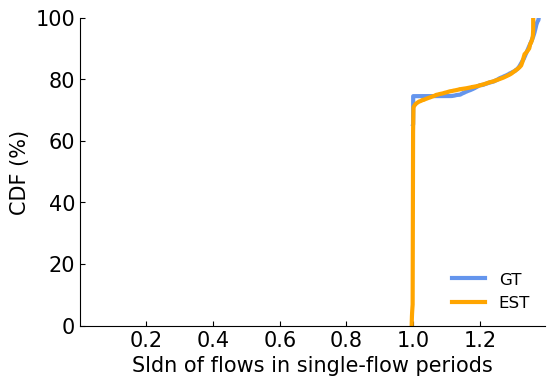

In [3]:
dir_input_synthetic="/data2/lichenni/path_perflow_link"
dir_output="/data2/lichenni/output_perflow"
program_name_list=[
                'fct_lstm_uniform_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                'fct_lstm_balanced_shard2000_nflows1_nhosts1_nsamples1_lr10Gbps',
                ]
version_id_list=[
    [0],[0]
]

title_str_list = ["uniform","balanced"]
main_title_list=['test','empirical','empirical']
metric_label_list=["L1 Loss", "Relative error (%)"]

fig_index=0
for version_id_test in [1]:
    res_total_per_flow=[]
    num_total_per_flow=[]
    res_total_per_seg=[]
    num_total_per_seg=[]
    for program_name_idx,program_name in enumerate(program_name_list):
        for version_id in version_id_list[program_name_idx]:
            dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
            print(f"dir_train: {dir_train}")
            if version_id_test==0:
                f = open(f"{dir_train}/data_list.json", "r")
                data_list = json.loads(f.read())
                data_list_test=data_list["test"]
                dir_input=dir_input_synthetic
            else:
                data_list_test=[]
                dir_input=dir_input_synthetic+"_empirical"
                target_path=f'{dir_train}/test/version_{version_id_test}/'
                for shard in np.arange(1000):
                    for n_flows in [2000]:
                        for n_hosts in [21]:
                            src_dst_pair_target_str="_".join([str(x) for x in [0, n_hosts - 1]])
                            topo_type_cur = topo_type_ori.replace(
                                "-x_", f"-{n_hosts}_"
                            )
                            spec = f"shard{shard}_nflows{n_flows}_nhosts{n_hosts}_lr{lr}Gbps"
                            # statss = np.load(f'{dir_input}/{spec}/stats.npy', allow_pickle=True)
                            # print(statss.item())
                            # size_distribution_list=["cachefollower-all","hadoop-all","webserver-all"]
                            # if statss.item().get("size_dist_candidate") != 'webserver-all': continue
                            # if float(statss.item().get("load_bottleneck_target")) <= 0.3: continue
                            # if float(statss.item().get("ias_sigma_candidate")) < 1.5: continue
                            
                            for sample in [0]:
                                pattern=os.path.join(
                                        dir_train,
                                        'test',
                                        f'version_{version_id_test}',
                                        f'{spec}{topo_type_cur}s{sample}_i0_{src_dst_pair_target_str}_seg*'
                                    )
                                matching_directories = [d for d in glob.glob(pattern) if os.path.isdir(d)]
                                for matching_directory in matching_directories:
                                    segment_id=matching_directory.split("_seg")[-1]
                                    data_list_test.append(
                                        (spec, (0, n_hosts - 1), topo_type_cur+f"s{sample}_i0", int(segment_id), None)
                                    )
            
            len_tracks=len(data_list_test)
            
            # if len(data_list_test)>20000:
            #     data_list_test_idx=np.random.choice(len(data_list_test),20000, replace=False)
            #     data_list_test=[data_list_test[i] for i in data_list_test_idx]
            
            print(f"{program_name} loads {len_tracks} tracks")
            res_per_flow=[[[],[]] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            num_per_flow=[[] for _ in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1)]
            res_per_seg=[]
            num_per_seg=[]
            
            num_flows_to_gt=[]
            for spec, src_dst_pair_target, topo_type, segment_id, _ in data_list_test:
                src_dst_pair_target_str = "_".join([str(x) for x in src_dst_pair_target])+f"_seg{segment_id}"
                data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}{topo_type}_{src_dst_pair_target_str}/res.npz')
                queue_len_est = data['est'].flatten()
                output = data['output'].flatten()
                dir_input_tmp=f"{dir_input}/{spec}"
                BDP=10*MTU
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                busy_periods=np.load(f"{dir_input_tmp}/period{topo_type}.npy", allow_pickle=True)
                busy_period=busy_periods[segment_id]
                fid=np.arange(int(busy_period[0]),int(busy_period[1])+1)
                fid_rank=fid-np.min(fid)
                if len(output)==1:
                    num_flows_to_gt.append([output[0],queue_len_est[0]])
                    # print(f"len(output): {len(output)}, {len(fid)}")  
                
                sizes_flowsim = np.load(f"{dir_input_tmp}/fsize.npy")
                sizes=sizes_flowsim[fid]

                bins=np.digitize(sizes,size_bucket_list)
                res_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,len(metric_label_list)))  
                num_per_bucket=np.zeros((len(SIZE_BUCKET_LIST_LABEL_OUTPUT)+1,2))
                
                for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
                    gt = np.extract(bins==i, output)
                    estimated = np.extract(bins==i, queue_len_est)
                    fid_rank_tmp=np.extract(bins==i, fid_rank)
                    fid_tmp=np.extract(bins==i, fid)
                    if len(gt)==0:
                        continue
                    res_per_flow[i][0].extend(np.abs(gt - estimated))
                    res_per_flow[i][1].extend(np.abs(gt - estimated)/gt*100)
                    num_per_flow[i].extend(fid_rank_tmp)
                    
                    res_per_bucket[i,0]=np.mean(np.abs(gt - estimated))
                    res_per_bucket[i,1]=np.mean(np.abs(gt - estimated)/gt)*100
                    num_per_bucket[i,0]=len(gt)
                    num_per_bucket[i,1]=np.min(fid_tmp)
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][0].extend(np.abs(output - queue_len_est))
                res_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][1].extend((np.abs(output - queue_len_est)/output*100))
                num_per_flow[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)].extend(fid_rank)
                res_per_bucket[-1,0]=np.mean(np.abs(output - queue_len_est))
                res_per_bucket[-1,1]=np.mean(np.abs(output - queue_len_est)/output)*100
                num_per_bucket[-1,0]=len(output)
                num_per_bucket[-1,1]=np.min(fid)
                
                res_per_seg.append(res_per_bucket) 
                num_per_seg.append(num_per_bucket)
            res_total_per_flow.append(res_per_flow)
            num_total_per_flow.append(num_per_flow)
            res_total_per_seg.append(res_per_seg)
            num_total_per_seg.append(num_per_seg)
    res_total_per_seg=np.array(res_total_per_seg)
    print(res_total_per_seg.shape) 
    num_total_per_seg=np.array(num_total_per_seg)
    
    # for metric_idx in range(len(metric_label_list)):
    for metric_idx in [1]:
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[np.array(x[i][metric_idx]) for x in res_total_per_flow]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmean(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        plt.legend()
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[np.median(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per flow", fontsize="x-large")
        res=[(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)][metric_idx]) for x in res_total_per_flow]
        res_num=[np.digitize(x[len(SIZE_BUCKET_LIST_LABEL_OUTPUT)], balance_bins) for x in num_total_per_flow]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("Dist to the start of the period")
        plt.ylabel(f"# of flows")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(12, 6))
        plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
            res=[x[:,i,metric_idx] for x in res_total_per_seg]
            linelabels_list = []
            for j in range(len(program_name_list)):
                median_tmp=np.round(np.nanmean(res[j]),3)
                max_tmp=np.round(np.nanpercentile(res[j],99),3)
                linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))
            # print(res.shape)
            # print(np.nanmean(res,axis=1))
            plt.subplot(2, 2, i + 1)
            plot_cdf_sub(
                res,
                # f"./figs/{main_title_list[version_id_test]}-cdf{file_tag}",
                None,
                linelabels_list,
                x_label=f"{metric_label_list[metric_idx]}",
                y_label="CDF",
                log_switch=metric_idx==0,
                rotate_xaxis=False,
                ylim_low=0,
                # xlim=1,
                xlim_bottom=0.001,
                fontsize=15,
                legend_font=12,
                loc=4,
                title=f"{SIZE_BUCKET_LIST_LABEL_OUTPUT[i]}",
                enable_abs=True,
                group_size=5,
            )
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[np.median(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[np.digitize(x[:,-1,0],balance_bins) for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            stats_per_period=defaultdict(list)
            for i in range(len(res[j])):
                stats_per_period[res_num[j][i]].append(res[j][i])
            stats_per_period=dict(sorted(stats_per_period.items()))
            # for key in stats_per_period.keys():
            #     print(f"key: {key}, mean: {np.mean(stats_per_period[key])}, median: {np.median(stats_per_period[key])}, 99th: {np.percentile(stats_per_period[key],99)}")
            x_list=list(stats_per_period.keys())
            y_list=[len(stats_per_period[key]) for key in stats_per_period.keys()]
            plt.plot(x_list,y_list,label=f"{title_str_list[j]}-median")
        plt.legend()
        plt.xticks(ticks=np.arange(len(balance_bins_label)), labels=balance_bins_label,rotation=rotation_angle)
        # plt.xscale('log')
        plt.xlabel("#flows per busy period")
        plt.ylabel(f"# of periods")
        fig_index+=1
        
        plt.figure(fig_index,figsize=(6, 3))
        # plt.suptitle(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        # for i in range(len(SIZE_BUCKET_LIST_LABEL_OUTPUT)):
        #     res=[x[:,i,metric_idx] for x in res_total_per_seg]
        #     res_num=[x[:,i,1] for x in num_total_per_seg]
        #     plt.subplot(2, 2, i + 1)
        #     for j in range(len(program_name_list)):
        #         plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        #     plt.legend()
        #     plt.xlabel("#flows before busy period")
        #     plt.ylabel(f"{metric_label_list[metric_idx]}")
        plt.title(f"{main_title_list[version_id_test]} per busy period", fontsize="x-large")
        res=[x[:,-1,metric_idx] for x in res_total_per_seg]
        res_num=[x[:,-1,1] for x in num_total_per_seg]
        for j in range(len(program_name_list)):
            plt.scatter(res_num[j],res[j],label=title_str_list[j],s=1)
        plt.legend()
        plt.xlabel("#flows before busy period")
        plt.ylabel(f"{metric_label_list[metric_idx]}")
        fig_index+=1
        
        
        plot_cdf(
            np.array(num_flows_to_gt).transpose(),
            None,
            ['GT', 'EST'],
            x_label="Sldn of flows in single-flow periods",
            log_switch=False,
            rotate_xaxis=False,
            ylim_low=0,
            # xlim=1,
            xlim_bottom=0.001,
            fontsize=15,
            legend_font=12,
            loc=4,
            enable_abs=True,
            group_size=5,
            fig_idx=fig_index
        )
        fig_index+=1